In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import (OneHotEncoder,
                                    LabelEncoder,
                                    OrdinalEncoder,
                                    StandardScaler, 
                                    MinMaxScaler,
                                    RobustScaler,
                                    FunctionTransformer)
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import(RandomForestRegressor, 
                            GradientBoostingRegressor, 
                            AdaBoostRegressor)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score,root_mean_squared_error


from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('/Users/suryasaikadali/Downloads/pw_skills/kaggle/insurance_prediction/artifacts/insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [4]:
x = df.drop(['region','sex','expenses'],axis = 1)
y = df[['expenses']]

In [5]:
x.head()

,age,bmi,children,smoker
0,19,27.9,0,yes
1,18,33.8,1,no
2,28,33.0,3,no
3,33,22.7,0,no
4,32,28.9,0,no


In [6]:
y.head()

,expenses
0,16884.92
1,1725.55
2,4449.46
3,21984.47
4,3866.86


In [62]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.20,random_state = 42)

In [63]:
x_train.shape,x_test.shape

((1070, 4), (268, 4))

In [64]:
x_train['smoker'].value_counts()

smoker
no     850
yes    220
Name: count, dtype: int64

In [65]:
x_test['smoker'].value_counts()

smoker
no     214
yes     54
Name: count, dtype: int64

In [9]:
numerical_cols = [i for i in x.columns if x[i].dtype in ('int','float')]

In [10]:
numerical_cols

['age', 'bmi', 'children']

In [11]:
ord_categorical_cols = [i for i in x.columns if x[i].dtype == 'O']

In [12]:
ord_categorical_cols

['smoker']

In [13]:
smoker_categories = [
    'no',
    'yes'
]

In [14]:
sc = StandardScaler()

In [31]:
# 1st experiment of preprocessing class 
class Preprocessor1:
    def __init__(self,x_train,x_test):
        self.x_train = x_train
        self.x_test = x_test

    def ord_pipeline(self):
        ode = OrdinalEncoder(categories=[smoker_categories])
        
        ord_encoded_train = pd.DataFrame(ode.fit_transform(self.x_train[ord_categorical_cols]),
                                         columns = ode.get_feature_names_out(ord_categorical_cols))
        ord_encoded_train = pd.DataFrame(sc.fit_transform(ord_encoded_train),
                                         columns = ode.get_feature_names_out(ord_categorical_cols))
        
        ord_encoded_test = pd.DataFrame(ode.transform(self.x_test[ord_categorical_cols]),
                                         columns = ode.get_feature_names_out(ord_categorical_cols))
        ord_encoded_test = pd.DataFrame(sc.transform(ord_encoded_test),
                                        columns = ode.get_feature_names_out(ord_categorical_cols))
        
        return(ord_encoded_train,ord_encoded_test)
        
    def num_pipeline(self):
        num_encoded_train = pd.DataFrame(sc.fit_transform(self.x_train[numerical_cols]),
                                         columns = numerical_cols)
        num_encoded_test = pd.DataFrame(sc.transform(self.x_test[numerical_cols]),
                                        columns = numerical_cols)
        
        return(num_encoded_train,num_encoded_test)

    def preprocessor(self):
   
        x_train_2,x_test_2 = self.ord_pipeline()
        x_train_3,x_test_3 = self.num_pipeline()

        self.x_train = pd.concat([x_train_2, x_train_3],
                                  axis = 1)
        self.x_test = pd.concat([x_test_2, x_test_3],
                                 axis = 1)
        
        return(self.x_train,self.x_test)
        
        

In [32]:
preprocessor1 = Preprocessor1(x_train,x_test)

In [33]:
new_train_1,new_test_1 = preprocessor1.preprocessor()

In [34]:
new_train_1

,smoker,age,bmi,children
0,1.975060,0.906079,-0.514975,-0.901419
1,-0.506314,-0.657217,2.229145,0.745028
2,-0.506314,-1.438865,-0.531309,0.745028
3,1.975060,-1.367806,-0.612979,-0.078195
4,1.975060,-0.870394,-0.939660,-0.901419
...,...,...,...,...
1132,-0.506314,-1.509924,0.138387,2.391475
1133,-0.506314,-0.017687,-1.086667,3.214698
1134,-0.506314,1.332433,-0.874324,-0.901419
1135,1.975060,-0.159804,2.784503,0.745028


In [35]:
new_test_1

,smoker,age,bmi,children
0,-0.506314,0.408667,-0.874324,0.745028
1,-0.506314,-0.230863,-0.090290,-0.901419
2,1.975060,1.758787,-0.596645,-0.901419
3,-0.506314,0.479726,-0.792654,1.568251
4,1.975060,-1.438865,0.220057,-0.901419
...,...,...,...,...
196,-0.506314,-1.438865,-0.988662,-0.078195
197,-0.506314,1.048197,-0.269964,0.745028
198,-0.506314,-1.509924,-0.694650,-0.901419
199,-0.506314,0.763962,-0.808988,-0.901419


In [29]:
norm_dist_col = [i for i in x.columns if x[i].dtype == 'int']

In [30]:
norm_dist_col

['age', 'children']

In [42]:
# 2nd experiment of preprocessing class with labelencoder
class Preprocessor2:
    def __init__(self,x_train,x_test):
        self.x_train = x_train
        self.x_test = x_test

    def column(self):
        # seperating the columns according to their dtypes
        norm_dist_col = [i for i in x.columns if x[i].dtype == 'int']
        right_skew_col = [i for i in x.columns if x[i].dtype == 'float']
        categorical_cols = [i for i in x.columns if x[i].dtype == 'O']

        return(norm_dist_col,
               right_skew_col,
               categorical_cols)
        
    def ord_pipeline(self):
        ode = OrdinalEncoder(categories=[smoker_categories])
        _,_,ord_categorical_cols = self.column()

        # applying ordinal encoder to categorical column
        ord_encoded_train = pd.DataFrame(ode.fit_transform(self.x_train[ord_categorical_cols]),
                                         columns = ord_categorical_cols)     
        ord_encoded_test = pd.DataFrame(ode.transform(self.x_test[ord_categorical_cols]),
                                         columns = ord_categorical_cols)

        # applying standard scaling to categorical column
        ord_encoded_train = pd.DataFrame(sc.fit_transform(ord_encoded_train),
                                         columns = ord_categorical_cols)
        ord_encoded_test = pd.DataFrame(sc.transform(ord_encoded_test),
                                        columns = ord_categorical_cols)
        
        return(ord_encoded_train,
               ord_encoded_test)

    def right_skewed(self):
        log_transformation = FunctionTransformer(np.log1p,validate = True)
        _,right_col,_ = self.column()

        # applying log transformation to right skewed numerical column
        right_encoded_train = pd.DataFrame(log_transformation.fit_transform(self.x_train[right_col]),
                                           columns = right_col)     
        right_encoded_test = pd.DataFrame(log_transformation.transform(self.x_test[right_col]),
                                          columns = right_col)

        # applying standard scaling to right skewed numerical column
        #right_encoded_train = pd.DataFrame(sc.fit_transform(right_encoded_train),
        #                                   columns = right_col)
        #right_encoded_test = pd.DataFrame(sc.transform(right_encoded_test),
         #                                 columns = right_col)

        return(right_encoded_train, 
               right_encoded_test)

    
    def norm_num_pipeline(self):
        norm_col,_,_ = self.column()

        # applying standard scaler to bmi column which is normally distributed
        num_encoded_train = pd.DataFrame(sc.fit_transform(self.x_train[norm_col]),
                                         columns = norm_col)
        num_encoded_test = pd.DataFrame(sc.transform(self.x_test[norm_col]),
                                        columns = norm_col)
        
        return(num_encoded_train,num_encoded_test)

    def preprocessor(self):
        
        x_train_1,x_test_1 = self.ord_pipeline()
        x_train_2,x_test_2 = self.right_skewed()
        x_train_3,x_test_3 = self.norm_num_pipeline()

        self.x_train = pd.concat([x_train_1,x_train_2, x_train_3],
                                  axis = 1)
        self.x_test = pd.concat([x_test_1,x_test_2, x_test_3],
                                 axis = 1)
        
        return(self.x_train,self.x_test)
        
        

In [43]:
preprocessor2 = Preprocessor2(x_train,x_test)

In [44]:
new_train_2,new_test_2 = preprocessor2.preprocessor()

In [45]:
new_test_2.head()

,smoker,bmi,age,children
0,-0.506314,3.265759,0.408667,0.745028
1,-0.506314,3.433987,-0.230863,-0.901419
2,1.975060,3.328627,1.758787,-0.901419
3,-0.506314,3.284664,0.479726,1.568251
4,1.975060,3.493473,-1.438865,-0.901419


In [46]:
new_train_2.head()

,smoker,bmi,age,children
0,1.975060,3.346389,0.906079,-0.901419
1,-0.506314,3.811097,-0.657217,0.745028
2,-0.506314,3.342862,-1.438865,0.745028
3,1.975060,3.325036,-1.367806,-0.078195
4,1.975060,3.250374,-0.870394,-0.901419


<Axes: xlabel='children', ylabel='Count'>

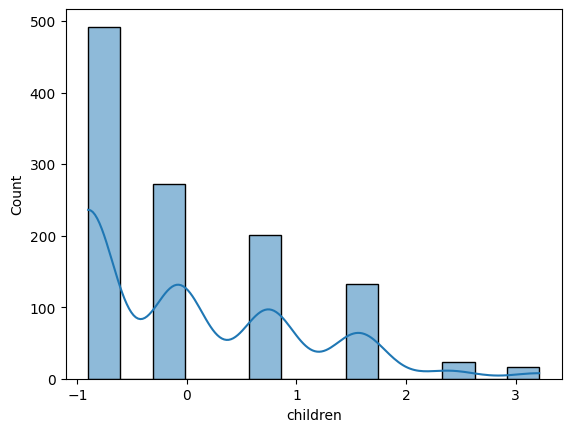

In [47]:
sns.histplot(data = new_train_2, x = 'children', kde = True)

In [36]:
models = {
    'xgb':XGBRegressor(),
    'random_forest':RandomForestRegressor(),
    'KNNregressor':KNeighborsRegressor(),
    'gradient_boost':GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'linear_reg': LinearRegression(),
    
}

In [37]:
def model_evaluation(x_train,x_test,y_train,y_test):
    total_scores_test = {}
    total_errors = {}
    for key,value in models.items():
        model = value.fit(x_train,y_train)
        
        y_pred = model.predict(x_test)
        
        score = r2_score(y_test,y_pred)
        
        error = root_mean_squared_error(y_test,y_pred)
        
        total_scores_test.update({key:score})
        total_errors.update({key:error})
        
    print(total_scores_test)
    print('%%%%%%%%%%%')
    print('%%%%%%%%%%%')
    print(total_errors)
    

In [38]:
model_evaluation(new_train_1,new_test_1,y_train,y_test)

{'xgb': 0.7962765097618103, 'random_forest': 0.8388333758903628, 'KNNregressor': 0.8538172232425931, 'gradient_boost': 0.874322158274964, 'adaboost': 0.8180527572889057, 'linear_reg': 0.7936827435435251}
%%%%%%%%%%%
%%%%%%%%%%%
{'xgb': 5569.606088257009, 'random_forest': 4953.83446854952, 'KNNregressor': 4717.935939017153, 'gradient_boost': 4374.549076365168, 'adaboost': 5263.524822406243, 'linear_reg': 5604.949617937337}


In [48]:
model_evaluation(new_train_2,new_test_2,y_train,y_test)

{'xgb': 0.7946451902389526, 'random_forest': 0.8381829754659428, 'KNNregressor': 0.8279016029509281, 'gradient_boost': 0.8742734370589759, 'adaboost': 0.8391970617938338, 'linear_reg': 0.7928254472278762}
%%%%%%%%%%%
%%%%%%%%%%%
{'xgb': 5591.861005651053, 'random_forest': 4963.820195953107, 'KNNregressor': 5119.085092852938, 'gradient_boost': 4375.396929476182, 'adaboost': 4948.241941839272, 'linear_reg': 5616.582482542318}


In [49]:
m1 = RandomForestRegressor(oob_score = True)

In [50]:
params = {
    'n_estimators': list(np.arange(150,401,50)),
    'max_depth': list(np.arange(1,8,2)),
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
        
}

In [51]:
gr_rand_for = GridSearchCV(estimator = m1,
                           param_grid = params, 
                           cv = 5,
                           scoring = 'r2',
                           verbose = 3)

In [52]:
gr_rand_for.fit(new_train_2,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END criterion=squared_error, max_depth=1, n_estimators=150;, score=0.619 total time=   0.1s
[CV 2/5] END criterion=squared_error, max_depth=1, n_estimators=150;, score=0.659 total time=   0.1s
[CV 3/5] END criterion=squared_error, max_depth=1, n_estimators=150;, score=0.552 total time=   0.1s
[CV 4/5] END criterion=squared_error, max_depth=1, n_estimators=150;, score=0.518 total time=   0.1s
[CV 5/5] END criterion=squared_error, max_depth=1, n_estimators=150;, score=0.641 total time=   0.1s
[CV 1/5] END criterion=squared_error, max_depth=1, n_estimators=200;, score=0.619 total time=   0.1s
[CV 2/5] END criterion=squared_error, max_depth=1, n_estimators=200;, score=0.659 total time=   0.1s
[CV 3/5] END criterion=squared_error, max_depth=1, n_estimators=200;, score=0.551 total time=   0.1s
[CV 4/5] END criterion=squared_error, max_depth=1, n_estimators=200;, score=0.518 total time=   0.1s
[CV 5/5] END criterion=square

GridSearchCV(cv=5, estimator=RandomForestRegressor(oob_score=True),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse', 'poisson'],
                         'max_depth': [1, 3, 5, 7],
                         'n_estimators': [150, 200, 250, 300, 350, 400]},
             scoring='r2', verbose=3)

In [53]:
best_params = gr_rand_for.best_params_

In [54]:
best_params

{'criterion': 'poisson', 'max_depth': 5, 'n_estimators': 350}

In [55]:
gr_rand_for.best_score_

0.8461245395003237

In [56]:
best_rf = RandomForestRegressor(**best_params,oob_score = True)

In [57]:
best_rf.fit(new_train_2,y_train)

RandomForestRegressor(criterion='poisson', max_depth=5, n_estimators=350,
                      oob_score=True)

In [58]:
y_pred = best_rf.predict(new_test_2)

In [59]:
r2_score(y_test,y_pred)

0.8646609740134357

In [39]:
best_rf_1 = RandomForestRegressor(criterion = 'poisson', 
                                  max_depth = 5,
                                  n_estimators = 250,
                                  oob_score = True)

In [40]:
best_rf_1.fit(new_train_1,y_train)

RandomForestRegressor(criterion='poisson', max_depth=5, n_estimators=250,
                      oob_score=True)

In [41]:
y_pred_1 = best_rf_1.predict(new_test_1)

In [42]:
r2_score(y_test,y_pred_1)

0.8658558854707471

In [34]:
best_rf.feature_importances_

array([0.71145598, 0.18633258, 0.09391617, 0.00829527])

In [35]:
best_rf.feature_names_in_

array(['smoker', 'age', 'bmi', 'children'], dtype=object)

In [40]:
m2 = GradientBoostingRegressor()

In [42]:
params = {
    'loss':['squared_error', 'absolute_error','huber'],
    'learning_rate':[0.03,0.06,0.09,0.1],
    'n_estimators': list(np.arange(100,301,50)),
    'max_depth': list(np.arange(1,8,2)),
    'criterion': ['squared_error', 'friedman_mse']
        
}

In [43]:
gr_boost = GridSearchCV(estimator = m2,
                        param_grid = params, 
                        cv = 5,
                        scoring = 'r2',
                        verbose = 3)

In [44]:
gr_boost.fit(new_train_1,y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV 1/5] END criterion=squared_error, learning_rate=0.03, loss=squared_error, max_depth=1, n_estimators=100;, score=0.669 total time=   0.1s
[CV 2/5] END criterion=squared_error, learning_rate=0.03, loss=squared_error, max_depth=1, n_estimators=100;, score=0.722 total time=   0.0s
[CV 3/5] END criterion=squared_error, learning_rate=0.03, loss=squared_error, max_depth=1, n_estimators=100;, score=0.680 total time=   0.0s
[CV 4/5] END criterion=squared_error, learning_rate=0.03, loss=squared_error, max_depth=1, n_estimators=100;, score=0.633 total time=   0.0s
[CV 5/5] END criterion=squared_error, learning_rate=0.03, loss=squared_error, max_depth=1, n_estimators=100;, score=0.680 total time=   0.0s
[CV 1/5] END criterion=squared_error, learning_rate=0.03, loss=squared_error, max_depth=1, n_estimators=150;, score=0.697 total time=   0.0s
[CV 2/5] END criterion=squared_error, learning_rate=0.03, loss=squared_error, max_depth=1,

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'learning_rate': [0.03, 0.06, 0.09, 0.1],
                         'loss': ['squared_error', 'absolute_error', 'huber'],
                         'max_depth': [1, 3, 5, 7],
                         'n_estimators': [100, 150, 200, 250, 300]},
             scoring='r2', verbose=3)

In [45]:
best_params = gr_boost.best_params_

In [46]:
best_params

{'criterion': 'friedman_mse',
 'learning_rate': 0.03,
 'loss': 'huber',
 'max_depth': 3,
 'n_estimators': 150}

In [71]:
best_params

{'criterion': 'friedman_mse',
 'learning_rate': 0.05,
 'loss': 'huber',
 'max_depth': 3,
 'n_estimators': 100}

In [47]:
gr_boost.best_score_

0.8479264131072384

In [48]:
best_gr = GradientBoostingRegressor(**best_params)

In [49]:
best_gr.fit(new_train_1,y_train)

GradientBoostingRegressor(learning_rate=0.03, loss='huber', n_estimators=150)

In [50]:
y_pred = best_gr.predict(new_test_1)

In [51]:
score = r2_score(y_test,y_pred)

In [52]:
score

0.8756142757763742

In [50]:
best_gr_1 = GradientBoostingRegressor(criterion= 'friedman_mse',
                                      learning_rate= 0.05,
                                      loss= 'huber',
                                      max_depth= 3,
                                      n_estimators= 100)

In [51]:
best_gr_1.fit(new_train_1,y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber')

In [52]:
y_pred_2 = best_gr_1.predict(new_test_1)

In [53]:
r2_score(y_test,y_pred_2)

0.8794216963396277

In [54]:
root_mean_squared_error(y_test,y_pred_2)

4284.878590855346

In [84]:
params = {
    'n_neighbors':list(np.arange(5,15,2)),
    'weights' : ['uniform', 'distance']
}

In [85]:
m3 = KNeighborsRegressor()

In [86]:
gr_knn_reg = GridSearchCV(estimator = m3, 
                          param_grid = params,
                          cv = 5, 
                          scoring = 'r2',
                          verbose = 3)

In [87]:
gr_knn_reg.fit(new_train_1,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ....n_neighbors=5, weights=uniform;, score=0.813 total time=   0.0s
[CV 2/5] END ....n_neighbors=5, weights=uniform;, score=0.883 total time=   0.0s
[CV 3/5] END ....n_neighbors=5, weights=uniform;, score=0.760 total time=   0.0s
[CV 4/5] END ....n_neighbors=5, weights=uniform;, score=0.755 total time=   0.0s
[CV 5/5] END ....n_neighbors=5, weights=uniform;, score=0.820 total time=   0.0s
[CV 1/5] END ...n_neighbors=5, weights=distance;, score=0.788 total time=   0.0s
[CV 2/5] END ...n_neighbors=5, weights=distance;, score=0.883 total time=   0.0s
[CV 3/5] END ...n_neighbors=5, weights=distance;, score=0.750 total time=   0.0s
[CV 4/5] END ...n_neighbors=5, weights=distance;, score=0.748 total time=   0.0s
[CV 5/5] END ...n_neighbors=5, weights=distance;, score=0.814 total time=   0.0s
[CV 1/5] END ....n_neighbors=7, weights=uniform;, score=0.819 total time=   0.0s
[CV 2/5] END ....n_neighbors=7, weights=uniform;

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [5, 7, 9, 11, 13],
                         'weights': ['uniform', 'distance']},
             scoring='r2', verbose=3)

In [88]:
best_params = gr_knn_reg.best_params_

In [89]:
best_params

{'n_neighbors': 13, 'weights': 'uniform'}

In [90]:
gr_knn_reg.best_score_

0.8239801140046084

In [91]:
best_knn = KNeighborsRegressor(**best_params)

In [92]:
best_knn.fit(new_train_1,y_train)

KNeighborsRegressor(n_neighbors=13)

In [93]:
y_pred = best_knn.predict(new_test_1)

In [94]:
r2_score(y_test,y_pred)

0.8651889304231466